# N2 molecule eigenvalue estimation using vqe and qpe and subsequently ITPE

In [1]:
import numpy as np
import os
import sys
import pyscf
from qiskit import QuantumCircuit
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import PhaseEstimation, TwoLocal
from qiskit.circuit.library import HamiltonianGate
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

### import nature library
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitMapper
import time
import inspect
from pprint import pprint

In [ ]:
# Define the molecule
driver = PySCFDriver(
    atom="N 0 0 0; N 0 0 1.0975",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

# Run the driver to get the problem
problem = driver.run()

# Define the log output (here using stdout)
flog = sys.stdout

### Apply freezecore transformer
transformer = FreezeCoreTransformer()
problem = transformer.transform(problem)

hamiltonian = problem.hamiltonian.second_q_op()
#print(hamiltonian)
print("\n".join(str(hamiltonian).splitlines()[:10] + ["..."]))

In [ ]:
print(problem.num_particles)
print(problem.num_spatial_orbitals)
#print(problem.active_orbitals)

In [ ]:
mapper = JordanWignerMapper()

pauli_hamiltonian = mapper.map(hamiltonian)
c = 0
for pauli, coeff in sorted(pauli_hamiltonian.label_iter()):
    c+= 1
    if c <10:
        print(f"{coeff.real:+.8f} * {pauli}")
    else:
        print("...")
        break

In [ ]:
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

as_transformer = ActiveSpaceTransformer(2,2) # syntax = AST(num_electrons,num_orbitals)
as_problem = as_transformer.transform(problem)

print(as_problem.num_particles)
print(as_problem.num_spatial_orbitals)

In [ ]:
print(as_problem.hamiltonian.electronic_integrals.alpha)

In [ ]:
hamiltonian = as_problem.hamiltonian.second_q_op()

#### Hilbert space reduction for pauli hamiltonian using AST

In [ ]:
#convert second quantized operator into pauli strings using any chemistry encoding of choice. we use jw.
mapper = JordanWignerMapper()

pauli_hamiltonian = mapper.map(hamiltonian)

for pauli, coeff in sorted(pauli_hamiltonian.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

In [ ]:
pauli_hamiltonian

In [ ]:
eig = np.linalg.eigvals(pauli_hamiltonian)
print('NUMPY eig',np.min(eig))

estimator = Estimator()
optimizer = SLSQP()
ansatz = TwoLocal(rotation_blocks=['ry', 'rz'], entanglement_blocks='cz')

vqe = VQE(estimator, ansatz, optimizer)
result = vqe.compute_minimum_eigenvalue(operator=pauli_hamiltonian)
print('VQE eig', result.eigenvalue)

In [ ]:
n_qpe_qbits = 10

U = HamiltonianGate(pauli_hamiltonian, 1, label='H')

# Obtain a solution via QPE
total_qbits = U.num_qubits + n_qpe_qbits
measure_circ = QuantumCircuit(total_qbits, n_qpe_qbits)
measure_circ.h([-1, -2])

qpe = PhaseEstimation(n_qpe_qbits, U)
Qpe=qpe.decompose().decompose().decompose().decompose().decompose().decompose().decompose()

In [ ]:
measure_circ = measure_circ.compose(Qpe)
measure_circ.measure(range(n_qpe_qbits), range(n_qpe_qbits))

In [ ]:
from qiskit_aer import Aer
backend=Aer.get_backend('aer_simulator')
job=backend.run(measure_circ,shots=10)
result=job.result()
counts = job.result().get_counts()
print(counts)

In [ ]:
max_count = max(counts.items(), key=lambda x: x[1])
print(f'MAX count: {max_count}')

theta = int(max_count[0][::-1], 2) / 2**n_qpe_qbits
print(f'Theta value: {theta}')
print(f'QPE-approximated U-eigenvalue: {np.exp(2*1j*np.pi * theta)}')
print(f'QPE-approximated H-eigenvalue: {-2 * np.pi * theta}')

## For different orientation of N2 molecule

In [2]:
driver = PySCFDriver(
    atom="N -1.05068773 0 0; N 1.05068773 0 0",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


# Run the driver to get the problem
problem = driver.run()

# Define the log output (here using stdout)
flog = sys.stdout

### Apply freezecore transformer
transformer = FreezeCoreTransformer()
problem = transformer.transform(problem)

hamiltonian = problem.hamiltonian.second_q_op()
#print(hamiltonian)
print("\n".join(str(hamiltonian).splitlines()[:10] + ["..."]))

Fermionic Operator
number spin orbitals=16, number terms=3288
  0.24020631525796152 * ( +_0 +_0 -_0 -_0 )
+ -0.020693007895257326 * ( +_0 +_0 -_2 -_0 )
+ 0.2316515617272311 * ( +_0 +_1 -_1 -_0 )
+ 0.02161361644566459 * ( +_0 +_1 -_7 -_0 )
+ -0.020693007895257326 * ( +_0 +_2 -_0 -_0 )
+ 0.2365639590463656 * ( +_0 +_2 -_2 -_0 )
+ 0.2356009307338203 * ( +_0 +_3 -_3 -_0 )
+ 0.23560093073382027 * ( +_0 +_4 -_4 -_0 )
...


In [3]:
print(problem.num_particles)
print(problem.num_spatial_orbitals)
#print(problem.active_orbitals)

(5, 5)
8


In [4]:
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

as_transformer = ActiveSpaceTransformer(2,2) # syntax = AST(num_electrons,num_orbitals)
as_problem = as_transformer.transform(problem)
print(as_problem.num_particles)
print(as_problem.num_spatial_orbitals)

(1, 1)
2


In [5]:
print(as_problem.hamiltonian.electronic_integrals.alpha)

Polynomial Tensor
 "+-":
array([[-7.20070885e-01,  3.96898253e-13],
       [ 3.96787231e-13, -8.32216763e-01]])
 "++--":
array([[[[ 4.97554008e-01,  1.50876707e-13],
         [ 1.50876707e-13,  4.60262920e-01]],

        [[ 1.50876707e-13,  2.11981207e-02],
         [ 2.11981207e-02, -1.41227308e-13]]],


       [[[ 1.50876707e-13,  2.11981207e-02],
         [ 2.11981207e-02, -1.41227308e-13]],

        [[ 4.60262920e-01, -1.41227308e-13],
         [-1.41227308e-13,  5.06340300e-01]]]])


In [6]:
hamiltonian = as_problem.hamiltonian.second_q_op()

#convert second quantized operator into pauli strings using any chemistry encoding of choice. we use jw.
mapper = JordanWignerMapper()

pauli_hamiltonian = mapper.map(hamiltonian)

for pauli, coeff in sorted(pauli_hamiltonian.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

-0.85165021 * IIII
+0.01081501 * IIIZ
+0.06469138 * IIZI
+0.10976620 * IIZZ
+0.01081501 * IZII
+0.12438850 * IZIZ
+0.11506573 * IZZI
+0.00529953 * XXXX
+0.00529953 * XXYY
+0.00529953 * YYXX
+0.00529953 * YYYY
+0.06469138 * ZIII
+0.11506573 * ZIIZ
+0.12658507 * ZIZI
+0.10976620 * ZZII


In [7]:
print(pauli_hamiltonian)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.85165021+0.j,  0.01081501+0.j,  0.06469138+0.j,  0.1097662 +0.j,
  0.01081501+0.j,  0.1243885 +0.j,  0.06469138+0.j,  0.11506573+0.j,
  0.00529953+0.j,  0.00529953+0.j,  0.00529953+0.j,  0.00529953+0.j,
  0.11506573+0.j,  0.12658507+0.j,  0.1097662 +0.j])


In [ ]:
eig = np.linalg.eigvals(pauli_hamiltonian)
print('NUMPY eig',np.min(eig))

estimator = Estimator()
optimizer = SLSQP()
ansatz = TwoLocal(rotation_blocks=['ry', 'rz'], entanglement_blocks='cz')

vqe = VQE(estimator, ansatz, optimizer)
result = vqe.compute_minimum_eigenvalue(operator=pauli_hamiltonian)
print('VQE eig', result.eigenvalue)

In [ ]:
n_qpe_qbits = 10

U = HamiltonianGate(pauli_hamiltonian, 1, label='H')

# Obtain a solution via QPE
total_qbits = U.num_qubits + n_qpe_qbits
measure_circ = QuantumCircuit(total_qbits, n_qpe_qbits)
measure_circ.h([-1, -2])

qpe = PhaseEstimation(n_qpe_qbits, U)
Qpe=qpe.decompose().decompose().decompose().decompose().decompose().decompose().decompose()

In [ ]:
measure_circ = measure_circ.compose(Qpe)
measure_circ.measure(range(n_qpe_qbits), range(n_qpe_qbits))

#measure_circ.draw("mpl")

In [ ]:
from qiskit_aer import Aer
backend=Aer.get_backend('aer_simulator')
job=backend.run(measure_circ,shots=10)
result=job.result()
counts = job.result().get_counts()
print(counts)

In [ ]:
max_count = max(counts.items(), key=lambda x: x[1])
print(f'MAX count: {max_count}')

theta = int(max_count[0][::-1], 2) / 2**n_qpe_qbits
print(f'Theta value: {theta}')
print(f'QPE-approximated U-eigenvalue: {np.exp(2*1j*np.pi * theta)}')
print(f'QPE-approximated H-eigenvalue: {-2 * np.pi * theta}')

In [ ]:
from qiskit_algorithms.phase_estimators.phase_estimator import PhaseEstimator

In [ ]:
eig = np.sort(eig)
eig

![quantum phase estimation circuit](qpe_circuit.png)
! <p style="text-align: center;">QPE circuit</p>

# Iterative QPE

### **refer to this [link to notebook for iqpe](https://github.com/qiskit-community/ibm-quantum-challenge-spring-2023/blob/main/content/lab_3/lab3.ipynb)**

Exponentiated pauli hamiltonian

### Method 1

In [8]:
from qiskit.circuit.library import PauliEvolutionGate

<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


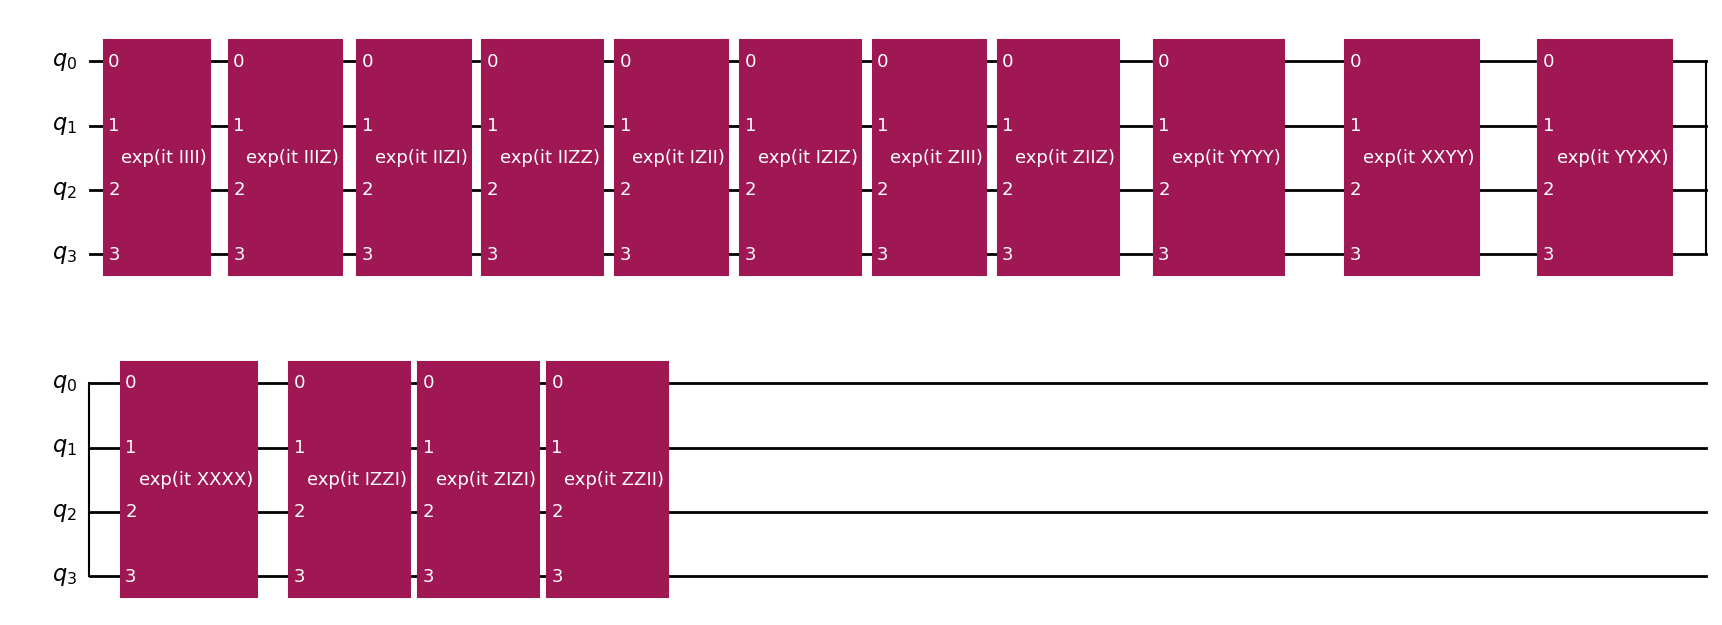

In [9]:
# Define parameters
n_qubits = 4  # active space
t = 1.0  # Time parameter
n_iterations = 100

# Create the unitary operator U = e^(-iHt)
instruct = PauliEvolutionGate(pauli_hamiltonian, time=1.0)
#print(type(U_2))
U_1 = QuantumCircuit(4)
U_1.append(instruct, range(4))
print(type(U_1))
U_draw = U_1.decompose()
U_draw.draw("mpl")

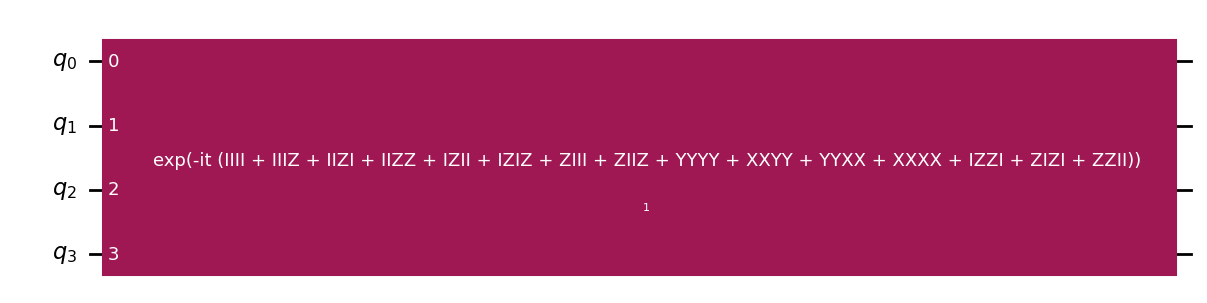

In [10]:
U_1.draw("mpl")

### Method 2

<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


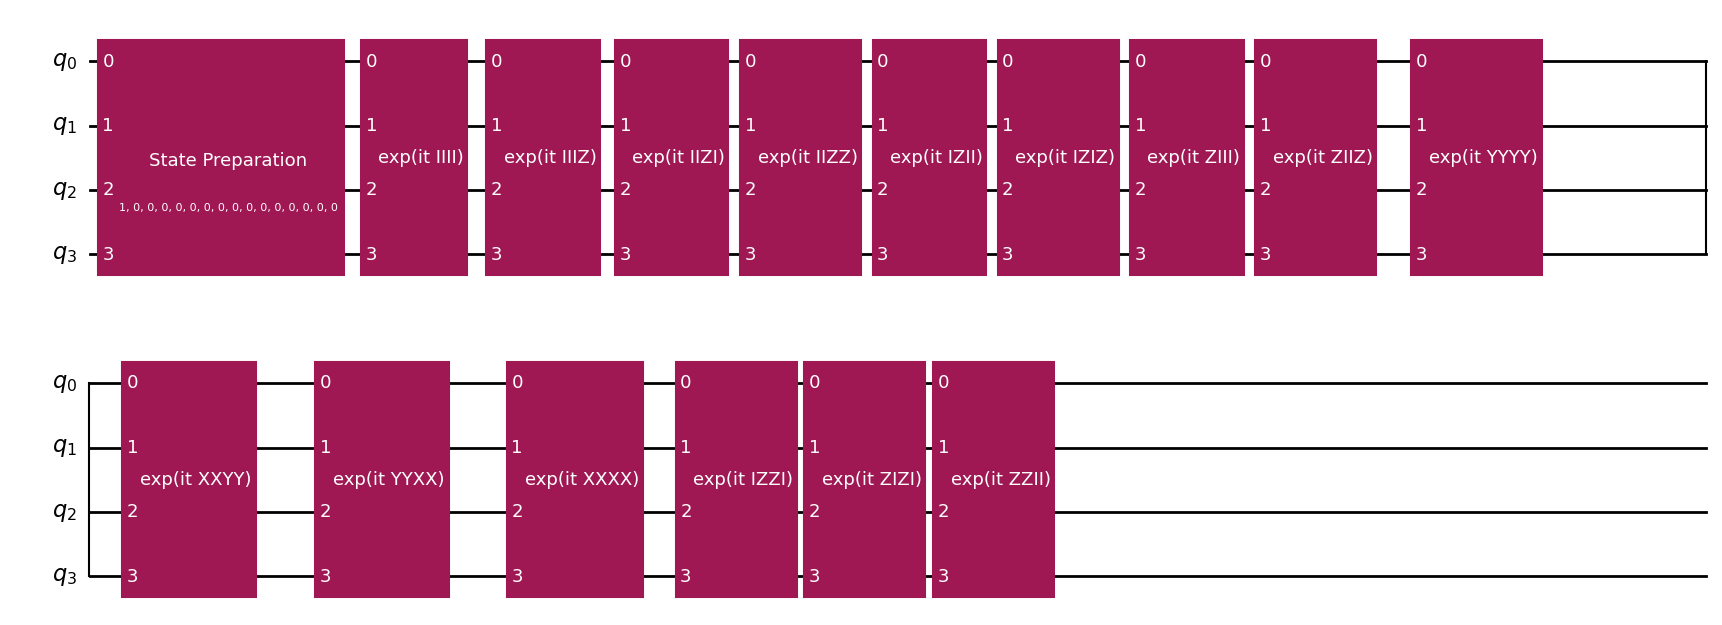

In [11]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE

initial_state = Statevector.from_label("0000")
problem = TimeEvolutionProblem(pauli_hamiltonian, initial_state=initial_state ,time=1.0)
trotter = TrotterQRTE()
result = trotter.evolve(problem)
U_2 = result.evolved_state
print(type(U_1))
U_2 = U_2.decompose()
U_2.draw("mpl")

## We will use method 1 i.e U_2

In [18]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

exp_ham_gate = U_1.to_gate(label = "U_ham_gate")

In [19]:
n_estimation_qubits = 10
n_system_qubits = U_2.num_qubits

qc = QuantumCircuit(n_estimation_qubits + n_system_qubits, n_estimation_qubits)

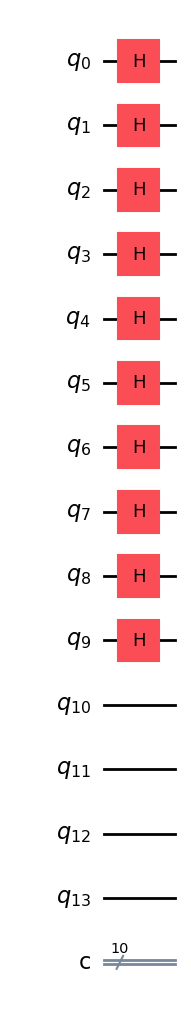

In [20]:
qc.h(range(n_estimation_qubits))
qc.draw("mpl")

In [21]:
iterations = 3
control_gate = U_2.control(1)

for _ in range(2**iterations):
        qc.append(control_gate,[0,10,11,12,13])

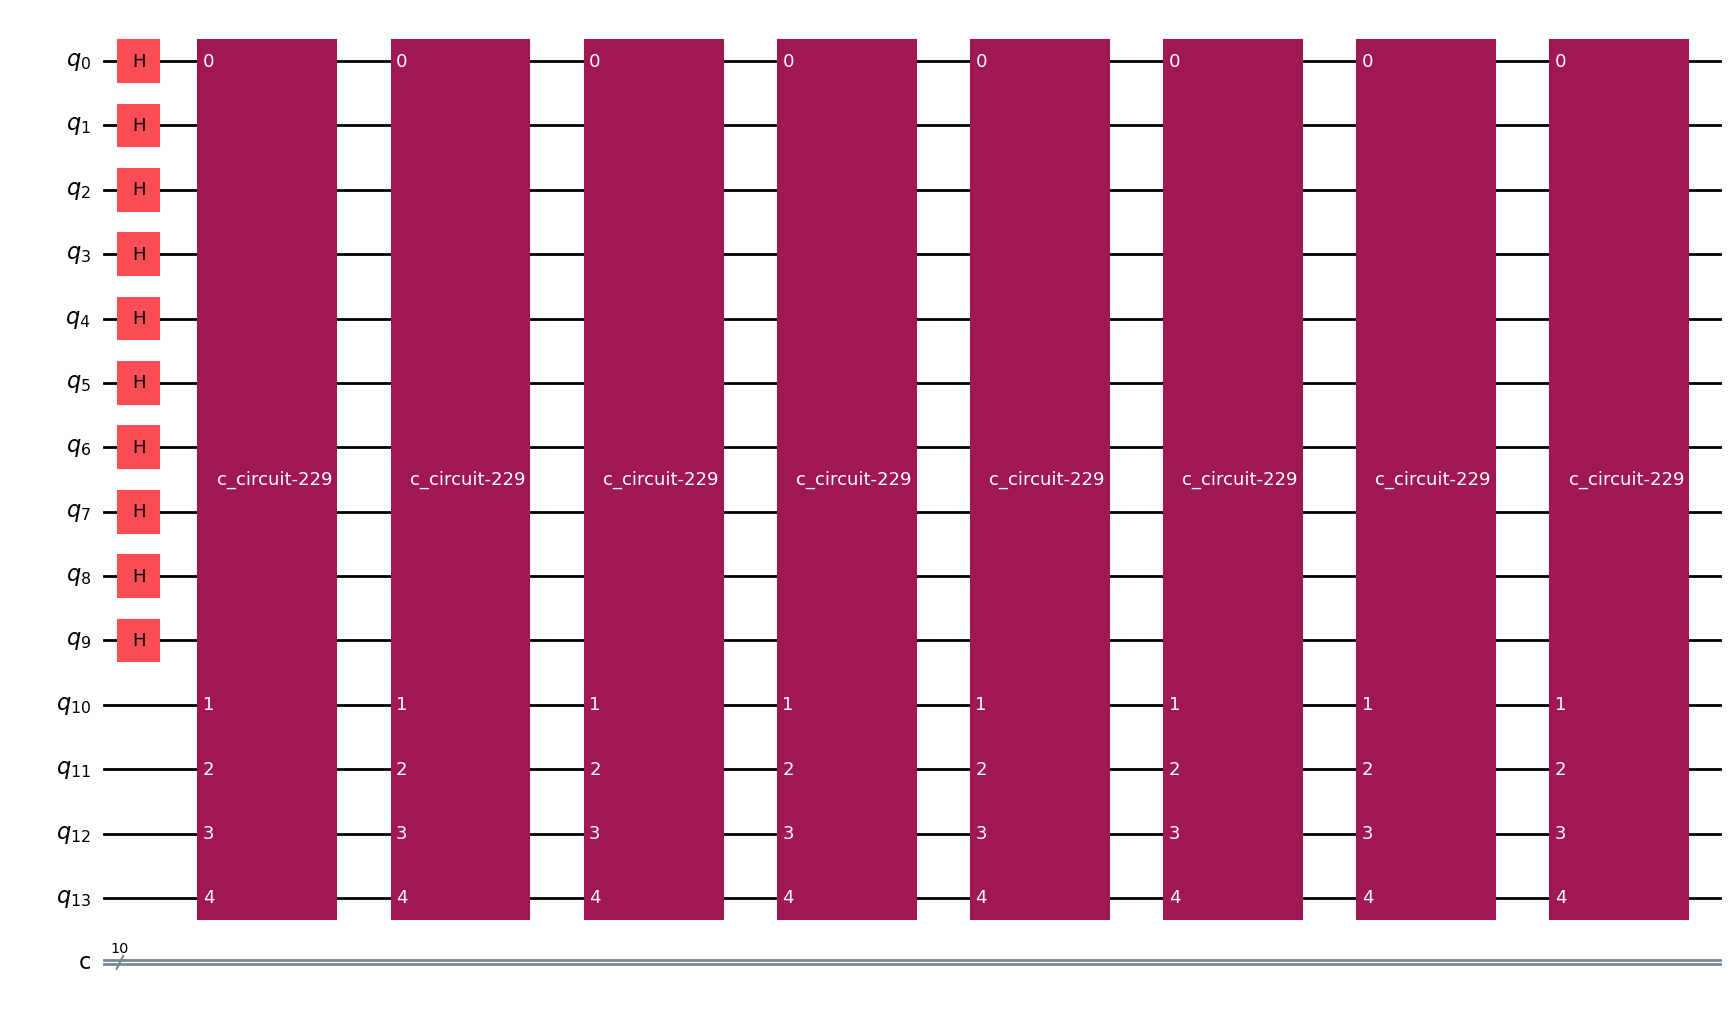

In [22]:
qc.draw("mpl")

In [ ]:
def iterative_phase_estimation(n_system_qubits, n_estimation_qubits, n_iterations):
    phase_estimate = 0
    
    for k in range(n_iterations):
        qc = create_iqpe_circuit(n_system_qubits, n_estimation_qubits, k)
        
        backend = Aer.get_backend('qasm_simulator')
        #job = execute(qc, backend, shots=1024)
        result = job.result().get_counts()
        
        if '1' in result and result['1'] > result.get('0', 0):
            phase_estimate += 1 / (2**(k+1))
        
        print(f"Iteration {k+1}: Current phase estimate = {phase_estimate}")
    
    return phase_estimate

In [ ]:
# Parameters
n_system_qubits = 4
n_estimation_qubits = 1
n_iterations = 10

# Run the iterative phase estimation
estimated_phase = iterative_phase_estimation(n_system_qubits, n_estimation_qubits, n_iterations)
estimated_phase